# Background
- **Author**: `<郭伊軒>`
- **Created At**: `<2025-11-1>`
- **Path to Training Data： discount-timing-DE.csv**
- **Path to Testing Data： discount-timing-DE.csv**
- **Model Specification 
    - Method：XGBoost classifer
    - Variables：  
    ['Age', 'PlayerGrowthRate1W', 'FollowersGrowthRate1W', 'PositiveRateGrowthRate1W', 'SalePeriod', 'AccumulatedPositiveRate', 'DLC_sum_1W', 'Sequel_sum_1W']
    - Tuning Parameters：
    - Optimization Method：
- **Main Findings and Takeaways：**
    - In-sample `<metric>`:
    - Out-sample `<metric>`:
- **Future Direciton：**

In [26]:
# Load packages here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix


In [27]:
# Load the TRAINING data here and please finish all the data manipulation here.
input_data_file = "/Users/10610/Desktop/114-1 資料/steam-project/discount-timing-DE.csv"
df = pd.read_csv(input_data_file)

df_dummies = pd.get_dummies(df, columns=['GameID'], drop_first=True)

train = df_dummies[df_dummies['Date'] < '2025-01-01']
test = df_dummies[df_dummies['Date'] >= '2025-01-01']

def prepare_xy(df, feature_cols, target_col):
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    # 將 bool 欄轉成 int
    X = X.astype({col: 'int' for col in X.select_dtypes(bool).columns})
    return X, y


In [28]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
GameID,23938.0,461376.742000,298559.181056,10.000000,244850.000000,431730.000000,644930.000000,1.145360e+06
MultiPlayer,23938.0,0.464241,0.498730,0.000000,0.000000,0.000000,1.000000,1.000000e+00
ConstantDiscount,23938.0,0.214387,0.410405,0.000000,0.000000,0.000000,0.000000,1.000000e+00
DiscountOrNot,23938.0,0.019885,0.139607,0.000000,0.000000,0.000000,0.000000,1.000000e+00
DiscountDuration,23938.0,0.221196,1.715483,0.000000,0.000000,0.000000,0.000000,3.200000e+01
DiscountFreq3M,23938.0,1.797644,1.043279,0.000000,1.000000,2.000000,3.000000,6.000000e+00
Age,23938.0,7.634427,4.458471,2.389041,4.951370,6.323288,8.479452,2.484658e+01
AccumulatedPositiveRate,23938.0,0.928061,0.064186,0.738751,0.905517,0.953165,0.972651,9.929734e-01
SalePeriod,23938.0,0.146420,0.353534,0.000000,0.000000,0.000000,0.000000,1.000000e+00
DiscountDuringSale,23938.0,0.008647,0.092590,0.000000,0.000000,0.000000,0.000000,1.000000e+00


### The actual modeling starts below
For the remaining blocks, make sure you have followed the guidelines as specified in [專案資料夾結構、檔案命名與文件規範](https://docs.google.com/document/d/1sl6gEFMdmiGsiNjLe17UmZ30xKxq15U0Mb2B-Jvusxg/edit?tab=t.33iie8ybx7s4).


In [29]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # --- 第一張圖：Weight (使用頻率) ---
    xgb.plot_importance(model, importance_type='weight', ax=axes[0])
    axes[0].set_title("Feature Importance (Weight/Frequency)")
    axes[0].set_xlabel("Frequency (Count)")

    # --- 第二張圖：Gain (增益/影響力) ---
    xgb.plot_importance(model, importance_type='gain', ax=axes[1])
    axes[1].set_title("Feature Importance (Gain/Impact)")
    axes[1].set_xlabel("Gain (Average improvement)")

    plt.tight_layout() # 自動調整佈局，避免標籤重疊
    plt.show()


    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print("Confusion matrix:\n", cm)
    return {"Model": name, "Accuracy": acc, "F1": f1, "AUC": auc}


# 1W

In [30]:
feature_cols = [
    'Age', 'PlayerGrowthRate1W', 'FollowersGrowthRate1W', 'PositiveRateGrowthRate1W', 
    'SalePeriod', 'AccumulatedPositiveRate', 'DLC_sum_1W', 'Sequel_sum_1W'
] + [col for col in df_dummies.columns if col.startswith('GameID_')]

### 所有折扣

In [31]:
X_train, y_train = prepare_xy(train, feature_cols, 'DiscountOrNot')
X_test, y_test = prepare_xy(test, feature_cols, 'DiscountOrNot')

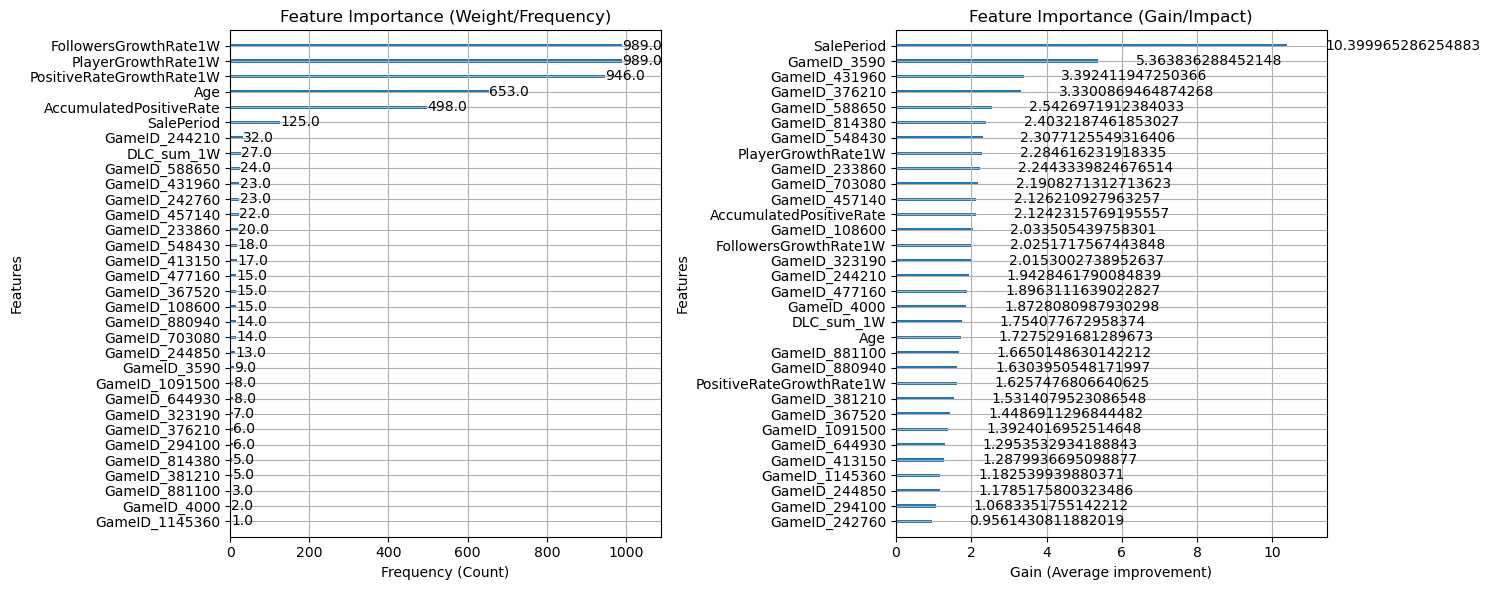


=== Baseline ===
Accuracy: 0.9815
F1-score: 0.0735
AUC: 0.6820
Confusion matrix:
 [[6691   10]
 [ 116    5]]


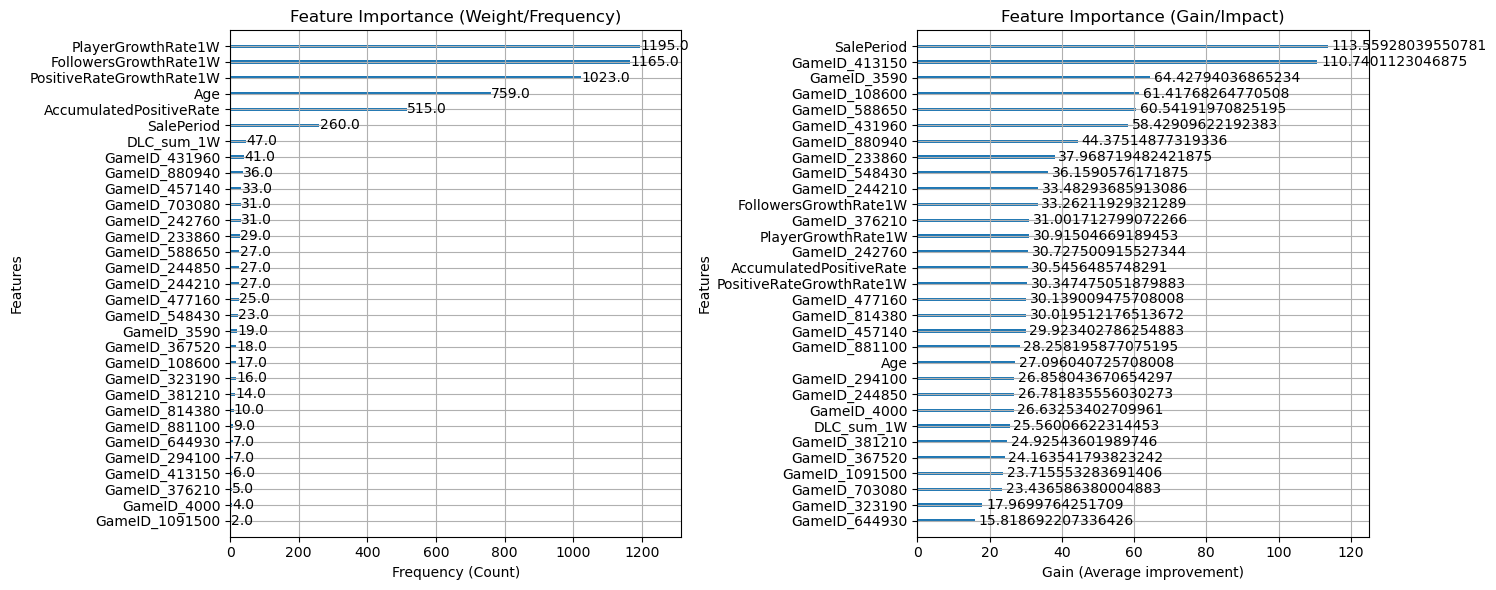


=== With scale_pos_weight ===
Accuracy: 0.9040
F1-score: 0.0788
AUC: 0.6650
Confusion matrix:
 [[6139  562]
 [  93   28]]

模型比較結果:
                   Model  Accuracy        F1       AUC
1  With scale_pos_weight  0.903987  0.078762  0.664958
0               Baseline  0.981530  0.073529  0.681969


In [32]:
baseline_model = XGBClassifier(
    objective='binary:logistic', 
    eval_metric='auc',        
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=71
)

pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
weighted_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=pos_weight,
    random_state=71
)
result1 = evaluate_model("Baseline", baseline_model, X_train, y_train, X_test, y_test)
result2 = evaluate_model("With scale_pos_weight", weighted_model, X_train, y_train, X_test, y_test)

results = pd.DataFrame([result1, result2])
print("\n模型比較結果:")
print(results.sort_values(by="F1", ascending=False))

### 季節性折扣

In [33]:
X_train, y_train = prepare_xy(train, feature_cols, 'DiscountDuringSale')
X_test, y_test = prepare_xy(test, feature_cols, 'DiscountDuringSale')

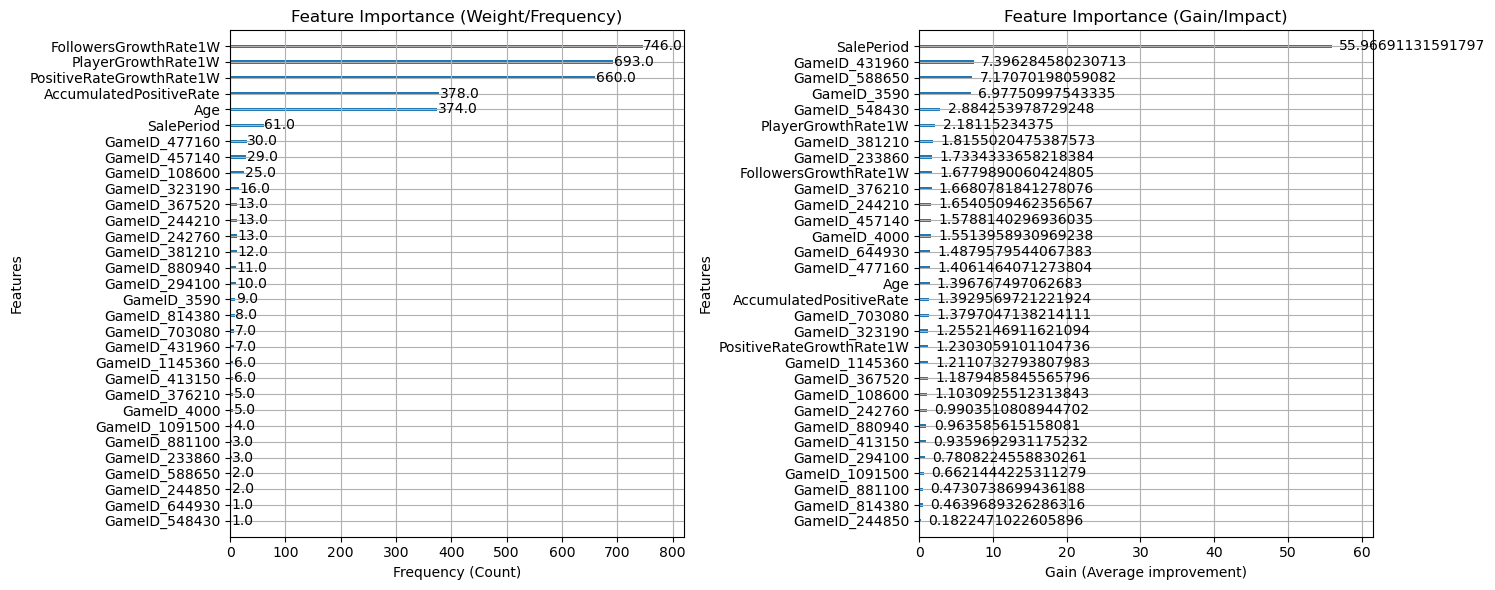


=== Baseline ===
Accuracy: 0.9937
F1-score: 0.2712
AUC: 0.9783
Confusion matrix:
 [[6771   23]
 [  20    8]]


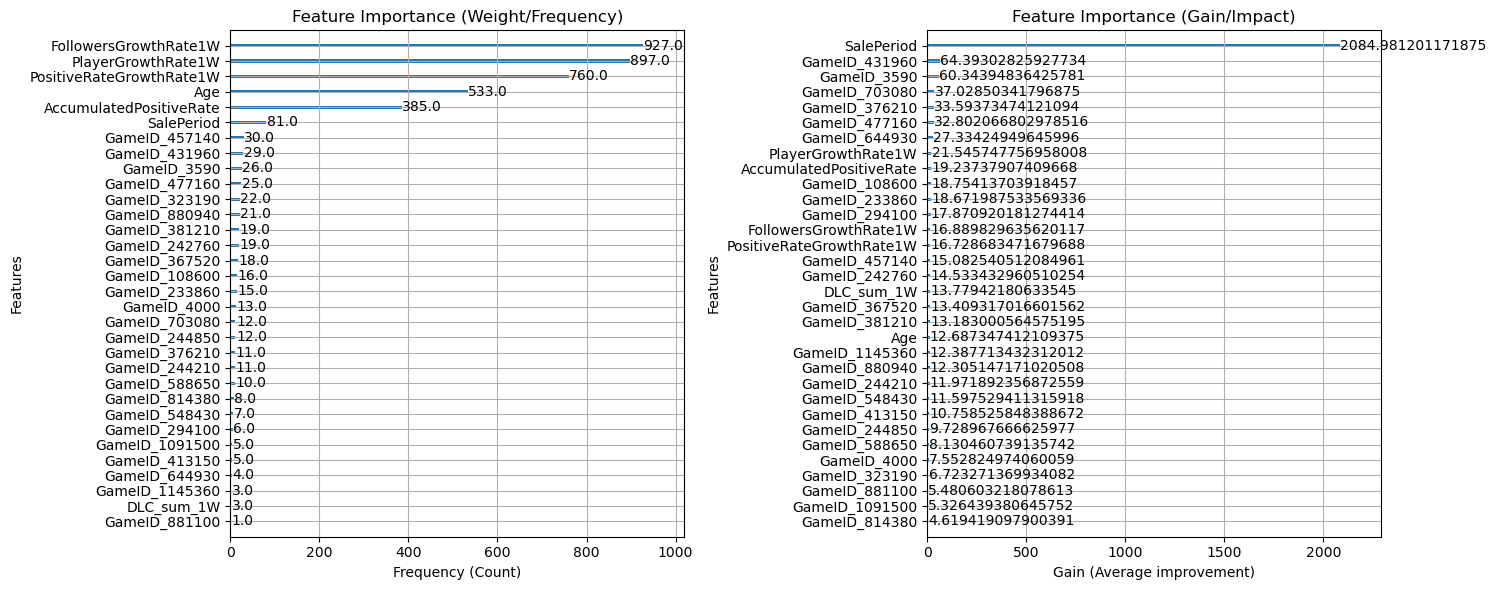


=== With scale_pos_weight ===
Accuracy: 0.9733
F1-score: 0.1651
AUC: 0.9758
Confusion matrix:
 [[6622  172]
 [  10   18]]

模型比較結果:
                   Model  Accuracy        F1       AUC
0               Baseline  0.993697  0.271186  0.978347
1  With scale_pos_weight  0.973322  0.165138  0.975808


In [34]:
baseline_model = XGBClassifier(
    objective='binary:logistic', 
    eval_metric='auc',        
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=71
)

pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
weighted_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=pos_weight,
    random_state=71
)
result1 = evaluate_model("Baseline", baseline_model, X_train, y_train, X_test, y_test)
result2 = evaluate_model("With scale_pos_weight", weighted_model, X_train, y_train, X_test, y_test)

results = pd.DataFrame([result1, result2])
print("\n模型比較結果:")
print(results.sort_values(by="F1", ascending=False))

### 非季節性折扣

In [35]:
X_train, y_train = prepare_xy(train, feature_cols, 'DiscountOutOfSale')
X_test, y_test = prepare_xy(test, feature_cols, 'DiscountOutOfSale')

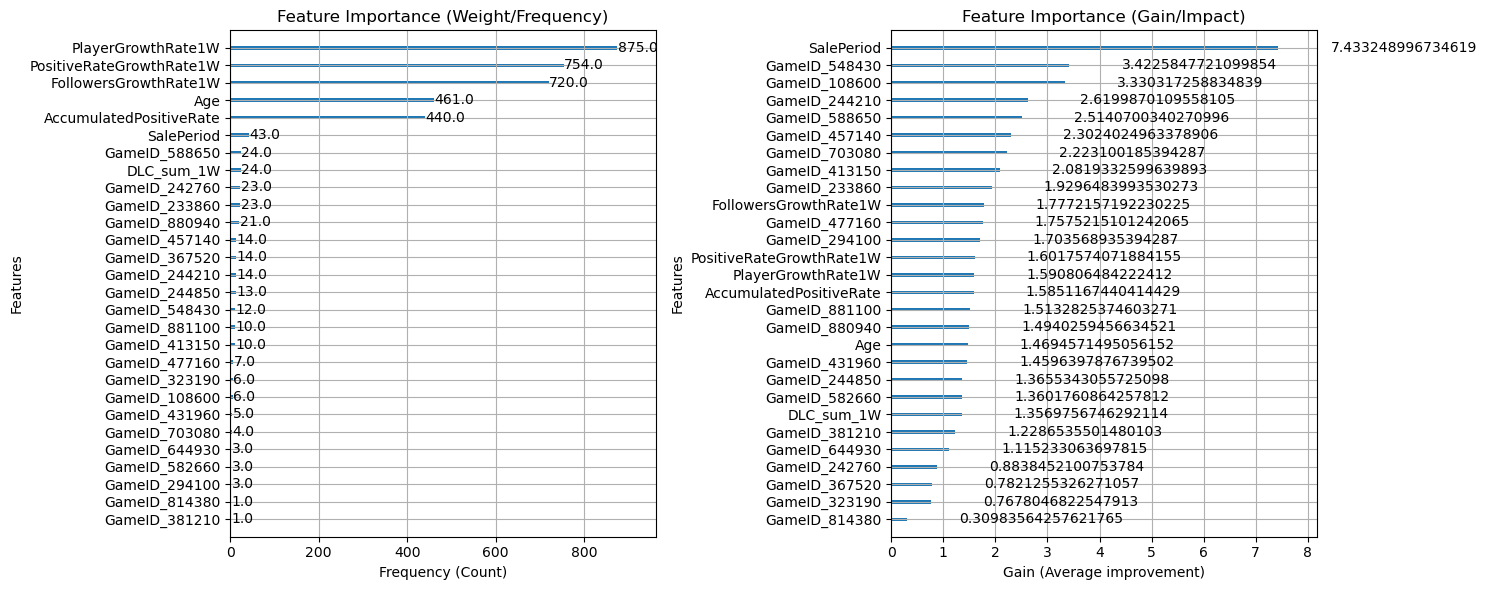


=== Baseline ===
Accuracy: 0.9864
F1-score: 0.0000
AUC: 0.6626
Confusion matrix:
 [[6729    0]
 [  93    0]]


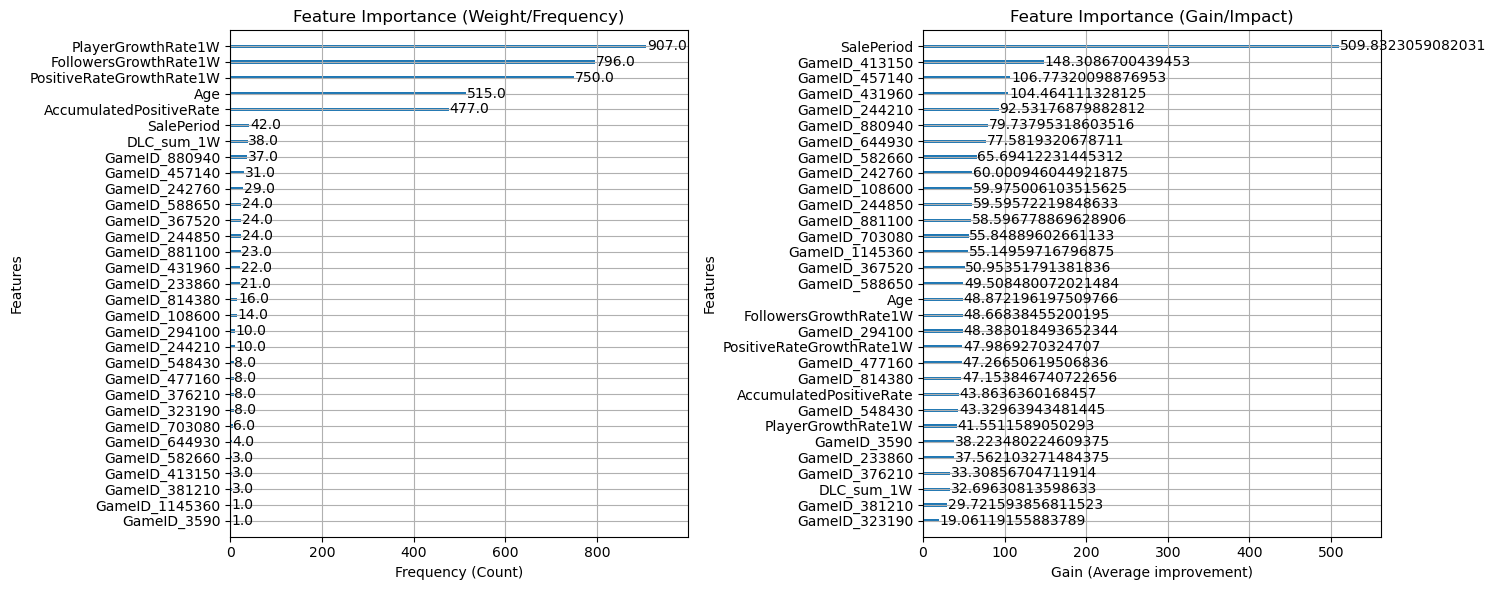


=== With scale_pos_weight ===
Accuracy: 0.9148
F1-score: 0.0428
AUC: 0.6431
Confusion matrix:
 [[6228  501]
 [  80   13]]

模型比較結果:
                   Model  Accuracy        F1       AUC
1  With scale_pos_weight  0.914834  0.042834  0.643079
0               Baseline  0.986368  0.000000  0.662554


In [36]:
baseline_model = XGBClassifier(
    objective='binary:logistic', 
    eval_metric='auc',        
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=71
)

pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
weighted_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=pos_weight,
    random_state=71
)
result1 = evaluate_model("Baseline", baseline_model, X_train, y_train, X_test, y_test)
result2 = evaluate_model("With scale_pos_weight", weighted_model, X_train, y_train, X_test, y_test)

results = pd.DataFrame([result1, result2])
print("\n模型比較結果:")
print(results.sort_values(by="F1", ascending=False))

# 增加遊戲類別

In [37]:
feature_cols = ['Age', "MultiPlayer", 'PlayerGrowthRate1W', 'FollowersGrowthRate1W', 'PositiveRateGrowthRate1W', 
                'SalePeriod', 'AccumulatedPositiveRate', 'DLC_sum_1W', 'Sequel_sum_1W']


In [38]:
X_train, y_train = prepare_xy(train, feature_cols, 'DiscountOrNot')
X_test, y_test = prepare_xy(test, feature_cols, 'DiscountOrNot')

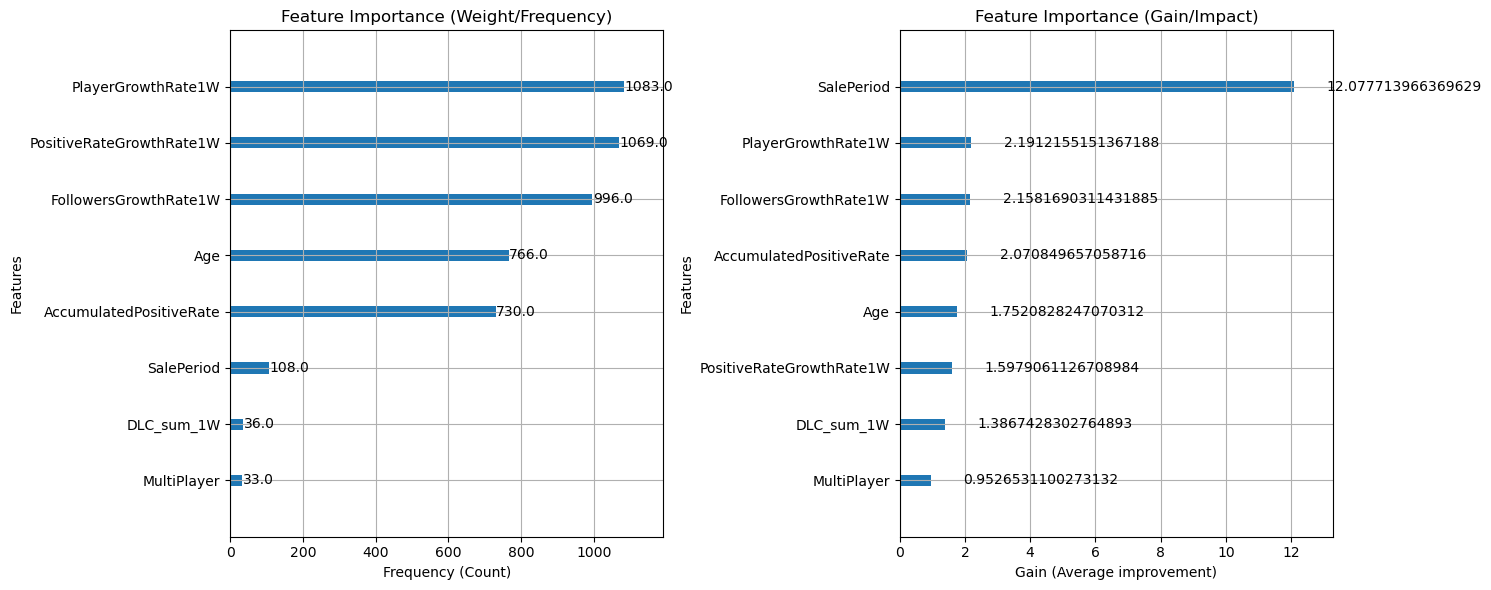


=== Baseline ===
Accuracy: 0.9805
F1-score: 0.0828
AUC: 0.6625
Confusion matrix:
 [[6683   18]
 [ 115    6]]


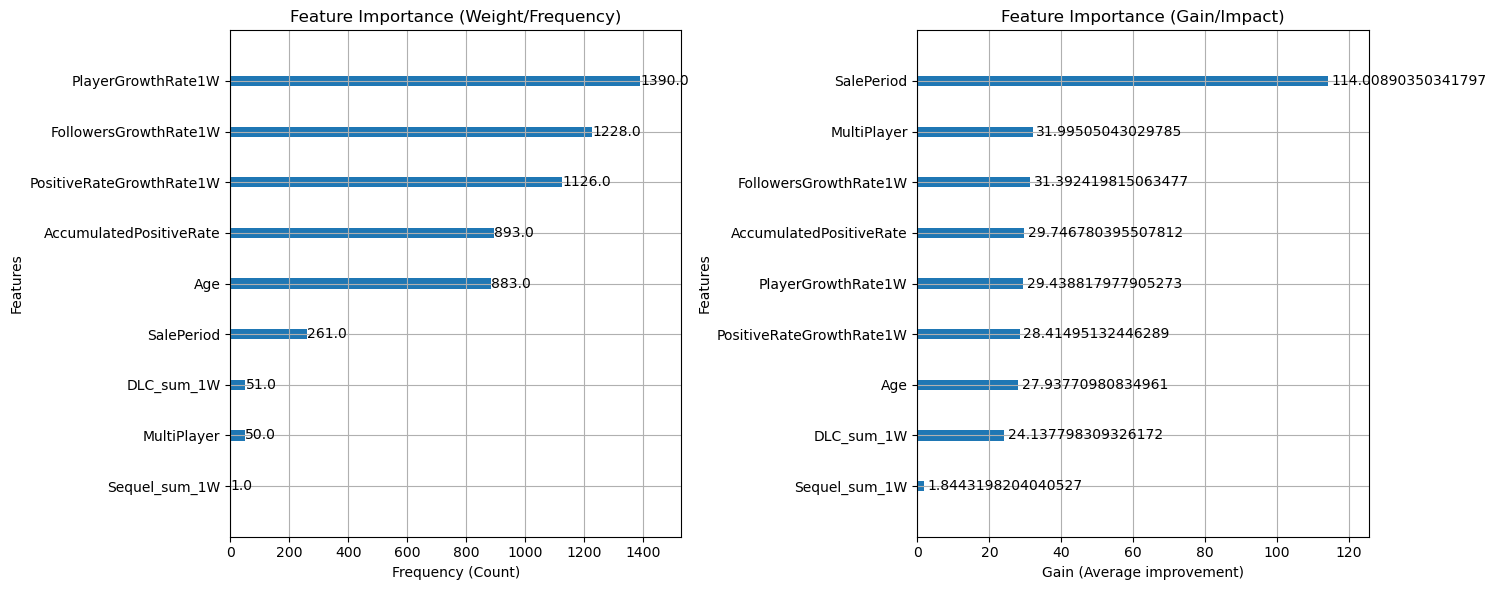


=== With scale_pos_weight ===
Accuracy: 0.9230
F1-score: 0.0838
AUC: 0.6594
Confusion matrix:
 [[6273  428]
 [  97   24]]

模型比較結果:
                   Model  Accuracy        F1       AUC
1  With scale_pos_weight  0.923043  0.083770  0.659445
0               Baseline  0.980504  0.082759  0.662549


In [39]:
baseline_model = XGBClassifier(
    objective='binary:logistic', 
    eval_metric='auc',        
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=71
)

pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
weighted_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=pos_weight,
    random_state=71
)
result1 = evaluate_model("Baseline", baseline_model, X_train, y_train, X_test, y_test)
result2 = evaluate_model("With scale_pos_weight", weighted_model, X_train, y_train, X_test, y_test)

results = pd.DataFrame([result1, result2])
print("\n模型比較結果:")
print(results.sort_values(by="F1", ascending=False))